In [1]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import os

In [2]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
#         print(images.shape)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [7]:
def transform(dataset):
    data_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=32,shuffle=True)
    mean,std=get_mean_std(data_loader)
    data_transform = transforms.Compose([
        transforms.Resize((255,255)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=32,shuffle=True,drop_last=False,num_workers=0)
    return data_loader,data_set

In [8]:
train_dataset='../Datasets/dataset_2_classes/test/'
train_loader,training_dataset=transform(train_dataset)

In [9]:
def show_transformed_images(dataset):
    loader=torch.utils.data.DataLoader(dataset, batch_size=12,shuffle=True)
    batch=next(iter(loader))
    images, labels=batch
    
    grid=torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels: ',labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])


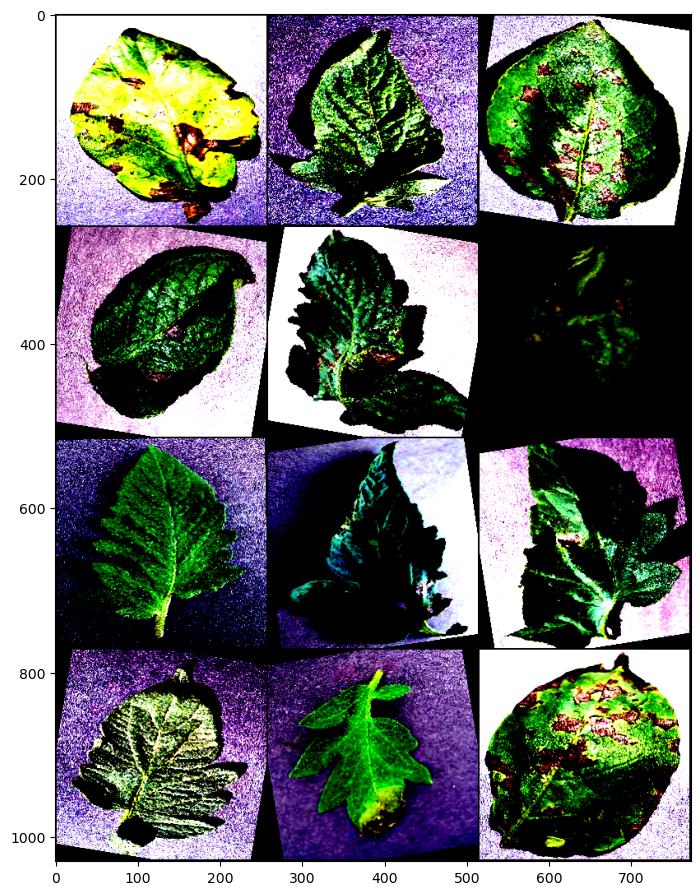

In [10]:
show_transformed_images(training_dataset)

In [11]:
validate_dataset='../Datasets/dataset_2_classes/validate/'
validate_loader,validating_dataset=transform(validate_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0])


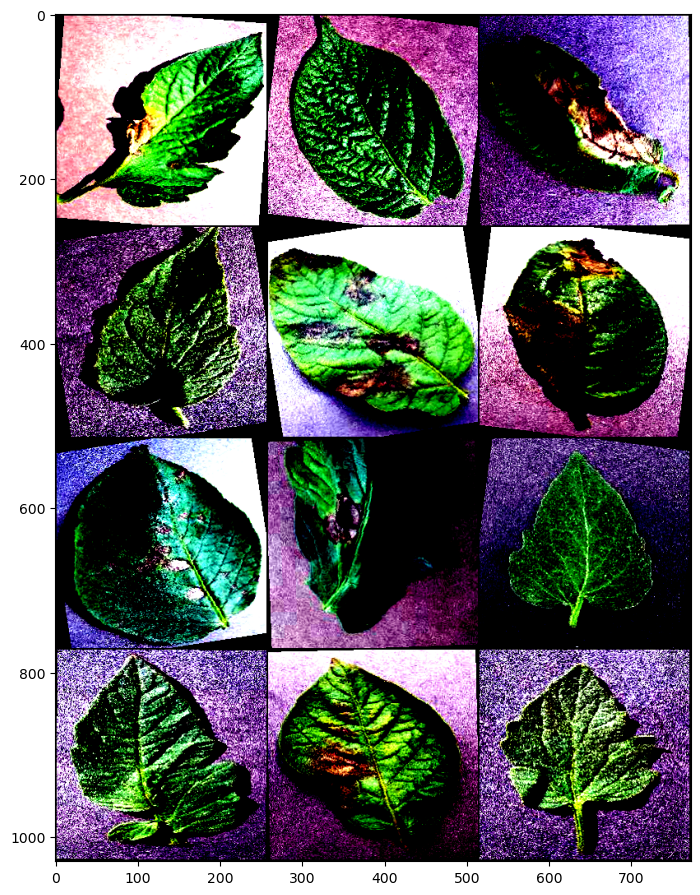

In [12]:
show_transformed_images(validating_dataset)

In [13]:
test_dataset='../Datasets/dataset_2_classes/test/'
test_loader,testing_dataset=transform(test_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


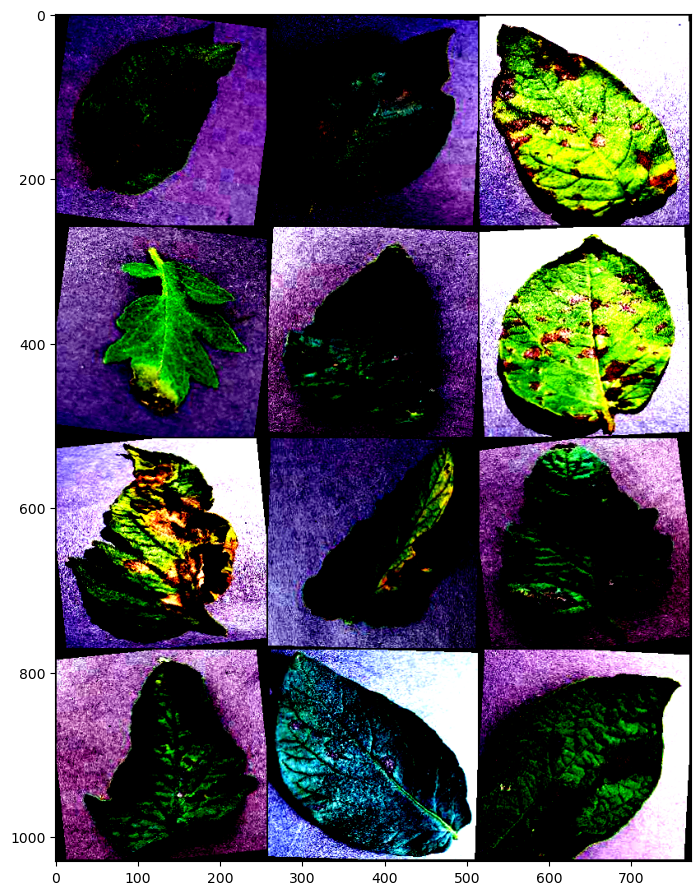

In [14]:
show_transformed_images(testing_dataset)

In [15]:
def set_device():
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    return device

In [16]:
mobilenet=models.mobilenet_v2(pretrained=False, num_classes = 2)

/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
count_parameters(mobilenet)

2226434

In [19]:
device=set_device()

In [20]:
mobilenet.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [21]:
print("Device: {}".format(device))

Device: mps


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mobilenet.parameters(), lr=0.0002,momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)
n_epochs = 100
epoch_count = 0
Accuracies = [] 
valAccuracies = []
valLoss = []
trainLoss = []
total_steps = len(train_loader)
t1 = time.time()
validation_accuracy = 0

In [25]:
for epoch in range(n_epochs):
    print("Epoch: %d "%(epoch+1))
    mobilenet.train()
    running_loss = 0.0
    running_correct = 0.0
    val_loss = 0.0
    total = 0
    for i,data in enumerate(train_loader):
        images,labels=data
        images=images.to(device)
        labels=labels.to(device)
        total+=labels.size(0)
        optimizer.zero_grad()
        outputs=mobilenet(images)
        _,predicted=torch.max(outputs.data,1)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        running_correct+=(labels==predicted).sum().item()
        traning_accuracy=(running_correct/total)*100
    
    validation_accuracy = 0
    mobilenet.eval()
    
    with torch.no_grad():
        val_correct=0
        val_total=0
        val_loss=0
        for data in validate_loader:
            images,val_labels=data[0].to(device), data[1].to(device)
            images = images.to(device)
            val_labels = val_labels.to(device)
            outputs=mobilenet(images)
            loss_val=criterion(outputs,val_labels)
            val_loss+= loss_val.item()
            _,predicted=torch.max(outputs.data,1)
            val_correct+=(predicted == val_labels).sum().item()
            val_total+=val_labels.size(0)
        validation_accuracy = (val_correct / val_total) *100

    scheduler.step()
    epoch_loss=running_loss/len(train_loader)
    val_loss=val_loss/len(validate_loader)
    epoch_accuracy=100.00* running_correct/total
    Accuracies.append(epoch_accuracy)
    valAccuracies.append(validation_accuracy)
    trainLoss.append(epoch_loss)
    valLoss.append(val_loss)
    
    print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f, Validation Loss: %.3f"%(epoch_loss,epoch_accuracy,val_loss))
    

Epoch: 1 
Training Data: Epoch Loss: 0.474, Epoch Accuracy: 81.152, Validation Loss: 0.609
Epoch: 2 
Training Data: Epoch Loss: 0.446, Epoch Accuracy: 81.152, Validation Loss: 0.565
Epoch: 3 
Training Data: Epoch Loss: 0.417, Epoch Accuracy: 82.324, Validation Loss: 0.525
Epoch: 4 
Training Data: Epoch Loss: 0.384, Epoch Accuracy: 87.598, Validation Loss: 0.486
Epoch: 5 
Training Data: Epoch Loss: 0.337, Epoch Accuracy: 87.305, Validation Loss: 0.413
Epoch: 6 
Training Data: Epoch Loss: 0.289, Epoch Accuracy: 90.820, Validation Loss: 0.345
Epoch: 7 
Training Data: Epoch Loss: 0.223, Epoch Accuracy: 91.895, Validation Loss: 0.335
Epoch: 8 
Training Data: Epoch Loss: 0.187, Epoch Accuracy: 94.141, Validation Loss: 0.297
Epoch: 9 
Training Data: Epoch Loss: 0.170, Epoch Accuracy: 94.336, Validation Loss: 0.264
Epoch: 10 
Training Data: Epoch Loss: 0.155, Epoch Accuracy: 95.312, Validation Loss: 0.251
Epoch: 11 
Training Data: Epoch Loss: 0.141, Epoch Accuracy: 95.215, Validation Loss: 0.2

Training Data: Epoch Loss: 0.052, Epoch Accuracy: 98.145, Validation Loss: 0.171
Epoch: 92 
Training Data: Epoch Loss: 0.052, Epoch Accuracy: 98.145, Validation Loss: 0.134
Epoch: 93 
Training Data: Epoch Loss: 0.038, Epoch Accuracy: 98.828, Validation Loss: 0.157
Epoch: 94 
Training Data: Epoch Loss: 0.042, Epoch Accuracy: 98.535, Validation Loss: 0.159
Epoch: 95 
Training Data: Epoch Loss: 0.034, Epoch Accuracy: 98.926, Validation Loss: 0.136
Epoch: 96 
Training Data: Epoch Loss: 0.048, Epoch Accuracy: 98.047, Validation Loss: 0.146
Epoch: 97 
Training Data: Epoch Loss: 0.038, Epoch Accuracy: 98.242, Validation Loss: 0.143
Epoch: 98 
Training Data: Epoch Loss: 0.043, Epoch Accuracy: 98.145, Validation Loss: 0.161
Epoch: 99 
Training Data: Epoch Loss: 0.039, Epoch Accuracy: 98.340, Validation Loss: 0.142
Epoch: 100 
Training Data: Epoch Loss: 0.033, Epoch Accuracy: 98.730, Validation Loss: 0.147


In [26]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [27]:
test_acc = evaluate_model(mobilenet,test_loader)

Testing Data: Epoch Accuracy: 99.512


Test Accuracy of the model on the 1024 test images: 99.609375 %


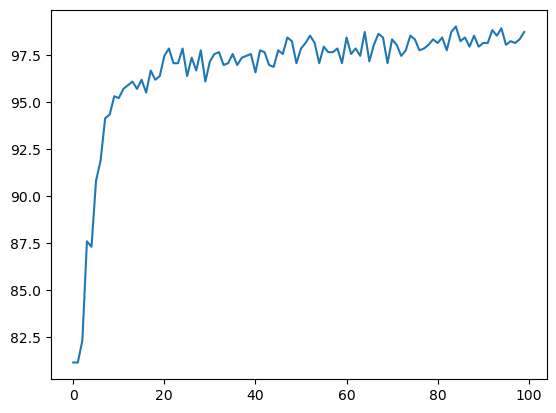

In [29]:
mobilenet.eval() 
perds = []
target = []
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = mobilenet(images)
        _, predicted = torch.max(outputs.data, 1)
        perds.extend(predicted)
        target.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))
    
plt.plot(Accuracies)

In [30]:
print(val_loss/len(validate_loader))

0.007007678899947816


In [31]:
dict = {'Training': Accuracies, 'Validation': valAccuracies} 
dictLoss = {'Training': trainLoss,'Validation': valLoss}
df = pd.DataFrame(dict)
df2 = pd.DataFrame(dictLoss)
df.to_csv("Accuracies_MobileNet_2classes"+str(epoch_count)+".csv")
df2.to_csv("Loss_Mobilenet_2classes"+str(epoch_count)+".csv")

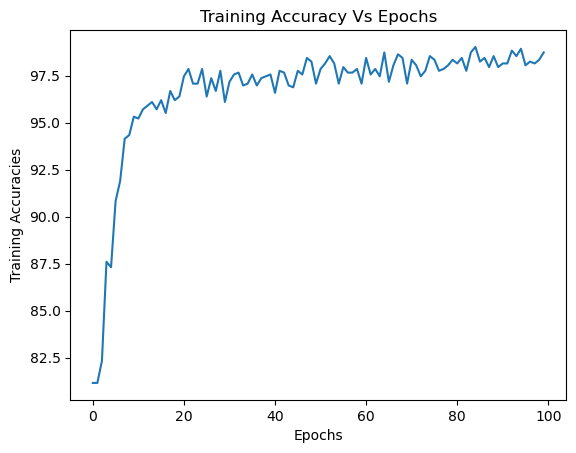

In [32]:
plt.plot(range(n_epochs),Accuracies)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracies")
plt.title("Training Accuracy Vs Epochs")
plt.show()

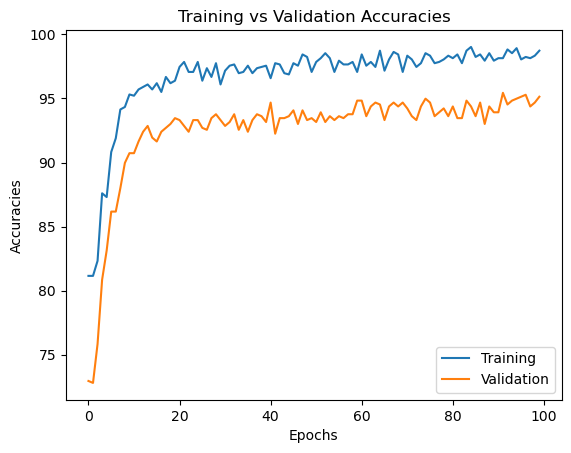

In [33]:
plt.plot(range(n_epochs),Accuracies, label="Training")
plt.plot(range(n_epochs),valAccuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training vs Validation Accuracies")
plt.legend()
plt.show()

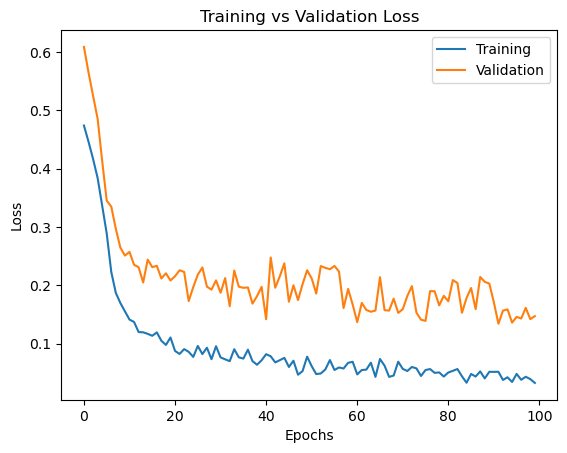

In [34]:
plt.plot(range(n_epochs),trainLoss, label="Training")
plt.plot(range(n_epochs),valLoss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay

In [37]:
y_pred = []
y_true = []

for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = mobilenet(inputs) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

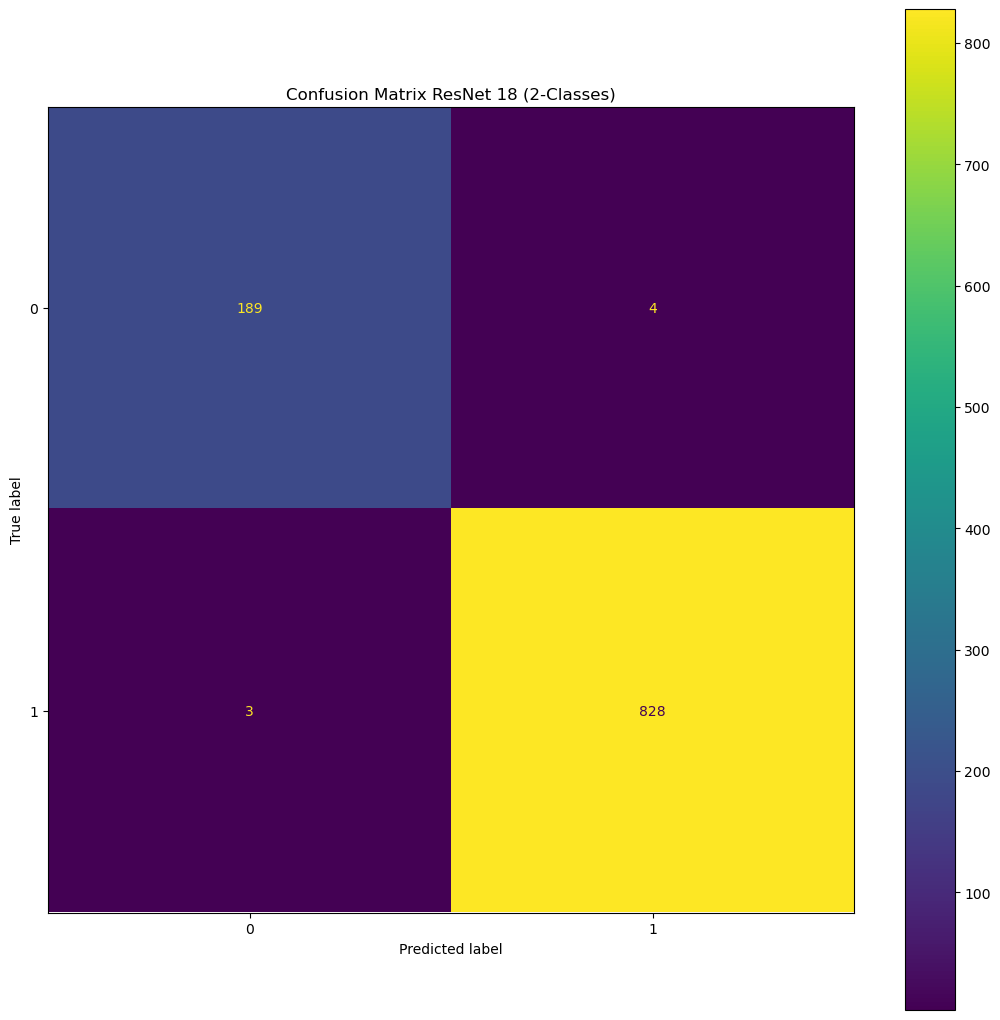

In [38]:
classes = (0,1)
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
fig,ax = plt.subplots()
fig.set_size_inches(13,13)
plt.title("Confusion Matrix ResNet 18 (2-Classes)")
disp.plot(ax=ax)
plt.show()

In [39]:
print("Precision Macro:{:.2f}".format(precision_score(y_true, y_pred, average='macro')))
print("Precision Micro:{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
print("Recall Macro:{:.2f}".format(recall_score(y_true,y_pred,average='macro')))
print("Recall Micro:{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
print("F1-Score Macro:{:.2f}".format(f1_score(y_true,y_pred,average='macro')))
print("F1-Score Micro:{:.2f}".format(f1_score(y_true,y_pred,average='micro')))

Precision Macro:0.99
Precision Micro:0.99
Recall Macro:0.99
Recall Micro:0.99
F1-Score Macro:0.99
F1-Score Micro:0.99
